# **DATA LOADING AND NORMALIZATION**

In [3]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score
from torchsummary import summary
import math

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224


def get_training_data(data_dir):
    data = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        #print(path)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                # Load and resize the image
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize the image
                
                # Add the image and label as a pair
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    
    # Convert the list to a NumPy array
    data = np.array(data, dtype=object)  # Use dtype=object to allow image-label pairing
    return data

# Load the data
train_data = get_training_data('../normData/train') 
test_data = get_training_data('../normData/test')
val_data = get_training_data( '../normData/val')

## **DATA Preparation**

Count of label 0: 3875
Count of label 1: 3875
Count of label 0: 8
Count of label 1: 8
Shape of train images: (7750, 224, 224)
Shape of validation images: (16, 224, 224)


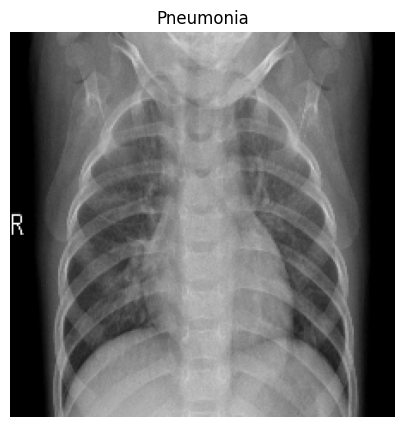

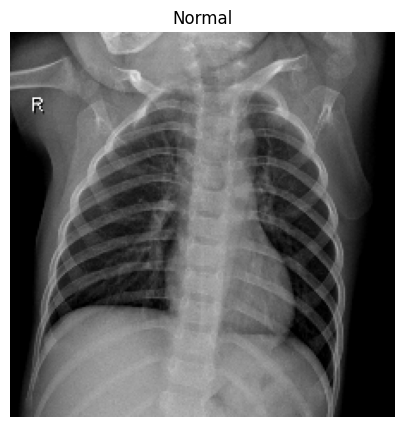

In [6]:
#Separate the images and the labels
train_images = np.array([x[0] for x in train_data])  # Extract only the images
train_labels = np.array([x[1] for x in train_data])  # Extract only the labels

# Initialize counts for each label
count_0 = 0
count_1 = 0

# Loop through the labels and count occurrences
for label in train_labels:
    if label == 0:
        count_0 += 1
    elif label == 1:
        count_1 += 1

# Print the results
print(f"Count of label 0: {count_0}")
print(f"Count of label 1: {count_1}")
    
val_images = np.array([x[0] for x in val_data])  # Extract only the images
val_labels = np.array([x[1] for x in val_data])  # Extract only the labels

count_0 = 0
count_1 = 0

# Loop through the labels and count occurrences
for label in val_labels:
    if label == 0:
        count_0 += 1
    elif label == 1:
        count_1 += 1

# Print the results
print(f"Count of label 0: {count_0}")
print(f"Count of label 1: {count_1}")
    
test_images = np.array([x[0] for x in test_data])  # Extract only the images
test_labels = np.array([x[1] for x in test_data])  # Extract only the labels

# Check the shape and an example of the dataset
print(f"Shape of train images: {train_images.shape}")
print(f"Shape of validation images: {val_images.shape}")

# Display the first image from the training data
plt.figure(figsize=(5, 5))
plt.imshow(train_images[0], cmap='gray')
plt.title('Pneumonia' if train_labels[0] == 0 else 'Normal')
plt.axis('off')
plt.show()

# Display the last image from the validation data
plt.figure(figsize=(5, 5))
plt.imshow(val_images[-1], cmap='gray')
plt.title('Pneumonia' if val_labels[-1] == 0 else 'Normal')
plt.axis('off')
plt.show()

# **KAN EFF**

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset
import math
from typing import *

# Function to flatten images
def flatten_images(images):
    return torch.flatten(images, start_dim=1)


train_images_tensor = torch.tensor(train_images)
val_images_tensor = torch.tensor(val_images)
test_images_tensor = torch.tensor(test_images)

train_images_flat = flatten_images(train_images_tensor)
val_images_flat = flatten_images(val_images_tensor)
test_images_flat = flatten_images(test_images_tensor)

train_labels_tensors = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensors = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_images_flat, train_labels_tensors)
val_dataset = TensorDataset(val_images_flat, val_labels_tensors)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )


# Setup and model initialization

input_dim = 224 * 224  # For example, 224*224 if that's your image size
layers_hidden = [input_dim, 128, 64, 10]  # Example layers configuration
model = KAN(layers_hidden)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Removed torchsummary import and summary call

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

def calculate_precision_recall(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')

    return precision, recall


In [8]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score

# Assume train_images_flat, val_images_flat, and their corresponding label tensors are provided
# They were created using the flattening and tensor conversion logic



# Labels are already in tensor form from the previous code
train_labels_tensor = train_labels_tensors
val_labels_tensor = val_labels_tensors

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_flat, train_labels_tensor)
val_dataset = TensorDataset(val_images_flat, val_labels_tensor)

# Define the batch size
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model and device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Correcting the input dimensions to match the flattened image dimensions
input_dim = train_images_tensor.shape[1]

# Define the loss function and optimizer 
criterion = nn.CrossEntropyLoss()  # For multi-class or binary classification
optimizer =  optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # AdamW with L2 regularization

# Now the data is ready for training and validation

# Function to calculate precision and recall
def calculate_precision_recall(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    
    return precision, recall

# Training function with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10):
    best_val_loss = float("inf")
    epochs_without_improvement = 0  # Count the number of epochs without improvement

    for epoch in range(num_epochs):
        model.train()  # Training mode
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(torch.float32).to(device), labels.to(torch.long).to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Compute metrics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")

        # Validation phase
        model.eval()  # Evaluation mode
        val_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(torch.float32).to(device), labels.to(torch.long).to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute the loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Compute metrics
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels).item()
                val_total_preds += labels.size(0)

        # Calculate validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct_preds / val_total_preds

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Calculate precision and recall on validation
        val_precision, val_recall = calculate_precision_recall(model, val_loader, device)
        print(f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")

        # Early Stopping: stop if no improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the model with the best validation loss
            torch.save(model.state_dict(), "best_model_eff.pth")
            print("Model saved!")
        else:
            epochs_without_improvement += 1
            print(f"Early Stopping Counter: {epochs_without_improvement}/{patience}")

        # If the number of epochs without improvement exceeds patience, stop
        if epochs_without_improvement >= patience:
            print("Early stopping triggered. Stopping training.")
            break

# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5)

Epoch 1/50
Train Loss: 6.2518, Train Accuracy: 0.7686
Validation Loss: 3.7690, Validation Accuracy: 0.4375
Validation Precision: 0.4000, Validation Recall: 0.2500
Model saved!
Epoch 2/50
Train Loss: 2.2875, Train Accuracy: 0.8476
Validation Loss: 5.8874, Validation Accuracy: 0.6250
Validation Precision: 1.0000, Validation Recall: 0.2500
Early Stopping Counter: 1/5
Epoch 3/50
Train Loss: 0.8466, Train Accuracy: 0.8677
Validation Loss: 0.9144, Validation Accuracy: 0.7500
Validation Precision: 1.0000, Validation Recall: 0.5000
Model saved!
Epoch 4/50
Train Loss: 0.9584, Train Accuracy: 0.8548
Validation Loss: 4.4760, Validation Accuracy: 0.5000
Validation Precision: 0.0000, Validation Recall: 0.0000
Early Stopping Counter: 1/5


C:\Users\rateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/50
Train Loss: 0.6188, Train Accuracy: 0.8773
Validation Loss: 0.7539, Validation Accuracy: 0.7500
Validation Precision: 0.6667, Validation Recall: 1.0000
Model saved!
Epoch 6/50
Train Loss: 0.4249, Train Accuracy: 0.8881
Validation Loss: 0.3318, Validation Accuracy: 0.8125
Validation Precision: 0.8571, Validation Recall: 0.7500
Model saved!
Epoch 7/50
Train Loss: 0.4590, Train Accuracy: 0.8769
Validation Loss: 0.5068, Validation Accuracy: 0.7500
Validation Precision: 0.8333, Validation Recall: 0.6250
Early Stopping Counter: 1/5
Epoch 8/50
Train Loss: 0.7180, Train Accuracy: 0.8770
Validation Loss: 0.3832, Validation Accuracy: 0.8125
Validation Precision: 1.0000, Validation Recall: 0.6250
Early Stopping Counter: 2/5
Epoch 9/50
Train Loss: 0.7183, Train Accuracy: 0.8761
Validation Loss: 0.3903, Validation Accuracy: 0.8125
Validation Precision: 0.7778, Validation Recall: 0.8750
Early Stopping Counter: 3/5
Epoch 10/50
Train Loss: 0.4035, Train Accuracy: 0.8996
Validation Loss: 0.2

In [11]:

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score

# Model and device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Correcting the input dimensions to match the flattened image dimensions
input_dim = train_images_flat.shape[1]  # Assuming train_images_flat was defined previously

# Define the model architecture using FastKAN
input_dim = 224 * 224  # For example, 224*224 if that's your image size
layers_hidden = [input_dim, 128, 64, 10]  # Example layers configuration
model = KAN(layers_hidden)
model = model.to(device)

# Load the saved model state
# Note: Be sure to use the appropriate path and file for your model
state_dict = torch.load("best_model_eff.pth", weights_only=True)
model.load_state_dict(state_dict, strict=False)

def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            
            correct_preds += torch.sum(preds == target).item()
            total_preds += target.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = correct_preds / total_preds

    return precision, recall, f1, accuracy

def validate_model(model, val_loader, device):
    precision, recall, f1, accuracy = calculate_metrics(model, val_loader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1-Score: {f1:.4f}")

# Validate the model on the validation dataset
validate_model(model, val_loader, device)

Validation Accuracy: 0.8750
Validation Precision: 1.0000
Validation Recall: 0.7500
Validation F1-Score: 0.8571


In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score

#Convert them to tensors if they aren't already
test_label_tensor = torch.tensor(test_labels, dtype=torch.long)
test_dataset = TensorDataset(test_images_flat, test_label_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)



def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            
            correct_preds += torch.sum(preds == target).item()
            total_preds += target.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = correct_preds / total_preds

    return precision, recall, f1, accuracy

def test_model(model, test_loader, device):
    precision, recall, f1, accuracy = calculate_metrics(model, test_loader, device)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

# Define and initialize your model using fast KAN

input_dim = 224 * 224  # For example, 224*224 if that's your image size
layers_hidden = [input_dim, 128, 64, 10]  # Example layers configuration
model = KAN(layers_hidden)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the saved model state
#model.load_state_dict(torch.load("best_model_v4.pth"))
#model.eval()

# Load the saved state_dict
state_dict = torch.load("best_model_eff.pth", weights_only=True)

model.load_state_dict(state_dict, strict=False)
model.load_state_dict(state_dict)


# Print the state_dict keys of your current model
current_state_dict = model.state_dict()
#print("Current Model State Dict Keys:", list(current_state_dict.keys()))

test_model(model, test_loader, device)

Test Accuracy: 0.7660
Test Precision: 0.8235
Test Recall: 0.4786
Test F1-Score: 0.6054
